In [1]:
# Import functions and libraries
from __future__ import division
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys
from numpy import *
from scipy import *
import scipy.signal as signal
from rtlsdr import RtlSdr
from numpy.fft import *

import serial
%matplotlib inline


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list



In [3]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

In [4]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 Built-in Microph
1 Built-in Output


In [5]:
# dusb_in = 2
# dusb_out = 2
din = 0
dout = 1

In [6]:
?RtlSdr

In [7]:
def recordSamples(sdr, N_samples, y):
    return y.put(sdr.read_samples(N_samples))

In [11]:
# sdr0.close()
# sdr1.close()
# sdr2.close()

In [2]:
sample_rate = 1e6 #240000
center_freq = 96.3e6 #97.3 #443.610e6
gain = 36
t_total = 4             # 8
N_samples = 1024000*t_total   # 256000

sdr0 = RtlSdr(device_index=0)
sdr1 = RtlSdr(device_index=1)
sdr2 = RtlSdr(device_index=2)
sdr0.sample_rate = sample_rate     # sampling rate  1000000
sdr0.center_freq = center_freq   # 162MhZ center frequency 162e6
sdr0.gain = gain 
sdr1.sample_rate = sample_rate     # sampling rate  1000000
sdr1.center_freq = center_freq   # 162MhZ center frequency 162e6
sdr1.gain = gain 
sdr2.sample_rate = sample_rate     # sampling rate  1000000
sdr2.center_freq = center_freq   # 162MhZ center frequency 162e6
sdr2.gain = gain 

y0 = Queue.Queue()
y1 = Queue.Queue()
y2 = Queue.Queue()

sdr0_rec = threading.Thread(target = recordSamples,   args = (sdr0, N_samples, y0))
sdr1_rec = threading.Thread(target = recordSamples,   args = (sdr1, N_samples, y1))
sdr2_rec = threading.Thread(target = recordSamples,   args = (sdr2, N_samples, y2))

# play audio from Queue 
sdr0_rec.start()
sdr1_rec.start()
sdr2_rec.start()

sdr0.close()
sdr1.close()
sdr2.close()

y0 = y0.get()
y1 = y1.get()
y2 = y2.get()

NameError: name 'recordSamples' is not defined

In [ ]:
m = 512
fs = sample_rate
fc = center_freq

myspectrogram_hann_ovlp(y0, m, fs, fc,dbf = 60)

myspectrogram_hann_ovlp(y1, m, fs, fc,dbf = 60)

myspectrogram_hann_ovlp(y2, m, fs, fc,dbf = 60)

In [ ]:
figure()

In [8]:
## BELOW DOESN'T WORK

## Play sounds

fs = 44100

# create a pyaudio object
p = pyaudio.PyAudio()

Qout = Queue.Queue()

Qout.put(y0)

play_audio(Qout, p, sample_rate, dout)

while not(Qout.empty()) :
    time.sleep(1)

Qout.put(y1)

play_audio(Qout, p, sample_rate, dout)

while not(Qout.empty()) :
    time.sleep(1)
    
Qout.put(y2)

while not(Qout.empty()) :
    time.sleep(1)
    
# kill the pyaudio device. The thread will have an exception and will quit. 
p.terminate()


IOError: [Errno Invalid sample rate] -9997

In [3]:
import cPickle

with open("parallel_samps.pkl", "rb") as f:
    samples = cPickle.load(f)

1


([0.0, 3.072],
 [315300000.0, 315331250.0],
 array([[-29.31362538 +0.j        , -32.76307153 +0.j        ,
         -33.20010669 +0.j        , ..., -33.50600102 +0.j        ,
         -17.02058516 +0.j        ,   0.00000000 +0.j        ],
        [ 17.64260481 -2.33810752j,  15.82228909 -0.78483788j,
          16.19456743 +1.11191059j, ...,  17.12828295 +0.44055228j,
           9.00328759+10.27314027j,   0.00000000 +0.j        ],
        [  0.71983538 +0.05240181j,   0.73257317 +0.10656681j,
           0.47030627 -0.5835456j , ...,  -0.63766526 +0.07557159j,
          -1.01379297 -7.0532785j ,   0.00000000 +0.j        ],
        ..., 
        [  0.12461952 +3.12993682j,  -0.26770082 -1.0194475j ,
          -0.13389065 +0.66328885j, ...,   0.36686485 +0.58628633j,
           0.68562751 -3.8432532j ,   0.00000000 +0.j        ],
        [  0.71983538 -0.05240181j,   0.73257317 -0.10656681j,
           0.47030627 +0.5835456j , ...,  -0.63766526 -0.07557159j,
          -1.01379297 +7.053278

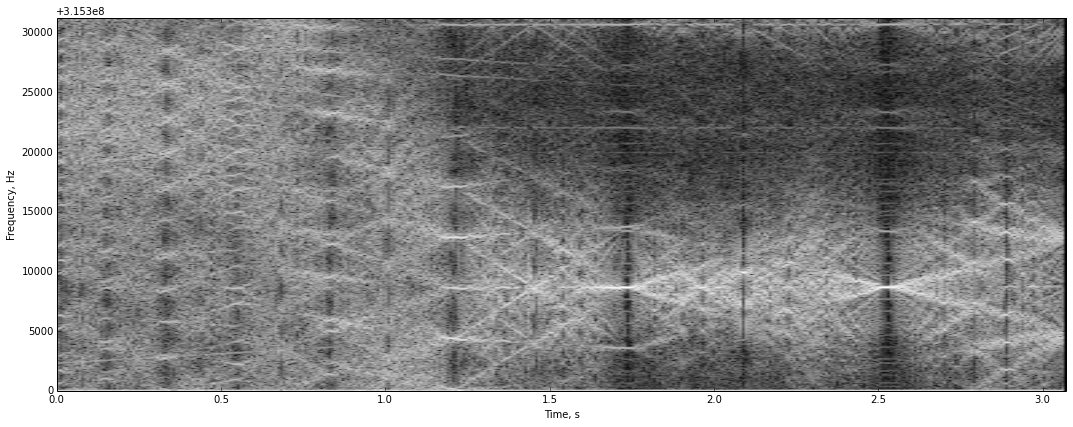

In [4]:
myspectrogram_hann_ovlp(np.angle(samples[0][:-1]*np.conj(samples[0][1:]))[::16], 1024, 1e6/16, 315.3e6,dbf = 60)

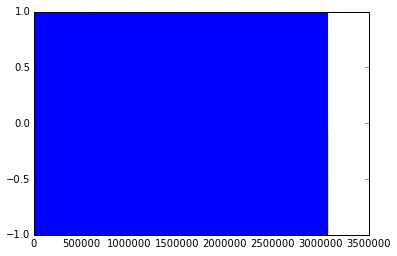

In [5]:
plt.plot(np.real(samples[0][:10000000]))

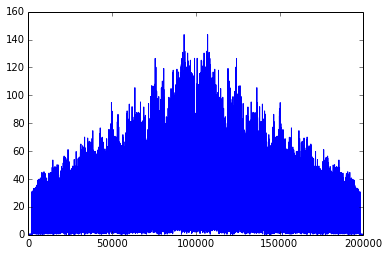

In [8]:
xcorr = signal.fftconvolve(samples[0][:100000], samples[0][:100000][::-1])

plt.plot(np.abs(xcorr))
#plt.plot(np.angle(np.fft.fft(xcorr)))